In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import gym
from gym import spaces
from gym.spaces import Box, Discrete
from collections import deque
import itertools
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler
import warnings
import os
import pickle
warnings.filterwarnings("ignore")

# create random number generator
rng = np.random.default_rng()

In [2]:
def get_data(name):
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv(name)
  return df.values    # get a numpy array
                      # each row corresponds one day

# 1st Split

In [3]:
train_1st = get_data("UltimateStocks.csv")[:-440]
train_1st

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [185.160004, 107.309998,  57.450001],
       [186.050004, 107.839996,  57.669998],
       [187.36    , 105.779999,  57.040001]])

In [4]:
test_1st = get_data("UltimateStocks.csv")[-440:]
test_1st

array([[190.039992, 108.75    ,  57.650002],
       [188.589996, 108.370003,  57.27    ],
       [188.149992, 107.379997,  57.130001],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

# 2nd split

In [5]:
train_2nd = get_data("train_2nd.csv")
train_2nd

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [6]:
test_2nd = get_data("test_2nd.csv")
test_2nd

array([[108.      ,  74.28    ,  55.62    ],
       [107.93    ,  75.52    ,  55.47    ],
       [108.18    ,  74.54    ,  55.47    ],
       ...,
       [185.160004, 107.309998,  57.450001],
       [186.050004, 107.839996,  57.669998],
       [187.36    , 105.779999,  57.040001]])

# 3rd split

In [7]:
train_3rd = get_data("train_3rd.csv")
train_3rd

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [8]:
test_3rd = get_data("test_3rd.csv")
test_3rd

array([[108.83 ,  63.94 ,  38.825],
       [109.7  ,  63.55 ,  38.865],
       [111.25 ,  63.7  ,  38.925],
       ...,
       [107.48 ,  73.5  ,  55.9  ],
       [108.37 ,  73.93 ,  55.36 ],
       [108.81 ,  74.28 ,  55.2  ]])

# 4th split

In [9]:
train_4th = get_data("train_4th.csv")
train_4th

array([[108.7     ,  63.42    ,  38.725   ],
       [109.01    ,  64.14    ,  38.895   ],
       [108.83    ,  63.94    ,  38.825   ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [10]:
test_4th = get_data("test_4th.csv")
test_4th

array([[ 67.8542,  60.3   ,  28.185 ],
       [ 68.5614,  60.9   ,  28.07  ],
       [ 66.8428,  60.83  ,  28.13  ],
       ...,
       [109.4   ,  64.68  ,  38.05  ],
       [108.6   ,  66.76  ,  38.355 ],
       [108.86  ,  64.46  ,  38.33  ]])

In [11]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here
  # To get parameter for the scaler, we must have some data
  # --> play an episode randomly and store each of the states we encounter. No need for an agent
  # For more accurate, run multiple episodes

  states = []
  for _ in range(env.n_step):
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    states.append(state)
    if terminated:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler


In [12]:
class MultiStockEnv(gym.Env):

  def __init__(self, data, initial_investment=20000):             # data = return of get_data()
    # data                                                        # get_data() returns a numpy array
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape    # (# day, 3)

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = Discrete(343)
    self.action_list = list(map(list, itertools.product([-1, -2/3, -1/3, 0, 1/3, 2/3, 1], repeat=self.n_stock)))
                                               # -1 = sell all stocks
                                               # 0 = hold
                                               # 1 = buy with all of our money

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1      # If we have N stocks, the state contains 2N+1 dimensions

    self.reset()


  def reset(self):
    self.cur_step = 0   # 1st day of stock prices
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]  # Stock price of each stock on the current day
    self.cash_in_hand = self.initial_investment                 # Not yet buy any stock, only initial investment
    return self._get_obs()                                      # Return the first state vector, done by get_obs()
                                                                # [0, 0, 0, 67.8542, 60.3, 28.185, 20000]



  def step(self, action):
    # assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]    # day -> next day, price -> price for next day
                                                                  # self.stock_price_history = data = train_data -- a numpy array

    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val 
    # done if we have run out of data
    terminated = self.cur_step == self.n_step - 1             # True when we reach the end of the series
                                                        # Realistically, stock markets never end, there is no termination
                                                        # In here, our code ends when there is no more data
    # store the current value of the portfolio here
    info = {'cur_val': cur_val}


    # conform to the Gym API
    return self._get_obs(), reward, terminated, False, info



  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned                  # List of 3, stock owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price    # List of 3, stock price
    obs[-1] = self.cash_in_hand                            # Cash in hands for last index
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand    # Total money



  def _trade(self, action):
    action_vec = self.action_list[action]     # returns a list of size 3

    # determine which stocks to buy or sell, we need this so that we can always buy before selling
    sell_info = [] # stores index and portion of stocks we want to sell
    buy_info = []  # stores index and portion of stocks we want to buy
        
    for i, a in enumerate(action_vec):   #[0.4, 0.3, -0.2]
      if a < 0:
        sell_info.append([i,a])      # gonna sell
        
      elif a > 0:
        buy_info.append([i,a])       # gonna buy
    # print('buy_info', buy_info)
    # print('sell_info', sell_info)
    

    # Buy before sell so that the money got from selling is only available in the next time-step
    if buy_info:
      new_action = []           # to store the actions only, which do not necessarily sum to 1 
      for (i,a) in buy_info: 
        new_action.append(a)
      
      if np.sum(new_action) > 1:        # Only softmax when their sum > 1
        new_buy = softmax(new_action)   # softmax so they sum to 1
      else:
        new_buy = new_action            # Keep the old action

      for i in range(len(buy_info)):
        buy_info[i][1] = new_buy[i]     # overwriting buy_info with our new softmaxed actions, or not
      # print(buy_info)
    

      total_cash_spent = 0                             # Need this so that we only subtract when we finish buying all stocks, to prevent overwriting self.cash_in_hand
      for (i,a) in buy_info:                           # If we buy, we buy using a% of our cash_in_hand
        cash_to_spend = self.cash_in_hand*a           
        if cash_to_spend > self.stock_price[i]:          # Check if we can afford at least 1 stock
          stock_bought = cash_to_spend // self.stock_price[i]
          self.stock_owned[i] += stock_bought
          cash_spent = stock_bought * self.stock_price[i]
          total_cash_spent += cash_spent
      total_cash_spent += total_cash_spent*0.0001   # 0.01% trade fee
      self.cash_in_hand -= total_cash_spent


    # Sell after buy
    if sell_info:                                   # [] - empty list also treated as None
      for (i,a) in sell_info:                       # If we sell, we sell a% of our stock_owned 
        stock_sold = -int(self.stock_owned[i]*a)    # minus because a is negative
        # print(stock_sold)
        self.stock_owned[i] -= stock_sold
        cash_increase = self.stock_price[i] * stock_sold
        self.cash_in_hand += cash_increase - cash_increase*0.0001  # 0.01% trade fee
     

In [13]:
# Q-network for approximating action-value function
class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):   # output_size = # of actions
        super().__init__()                                                      # input_size = size of state
        # create network layers
        layers = nn.ModuleList()            # example (3,32,32,2)
        
        # input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())



        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
        
        # output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
    
        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)    # *layers unpacked,   for example [1,2,3,4]  ---> 1,2,3,4
        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate)
    
    def forward(self, x):
        # return output of Q-network for the input x
        return self.net(x)
    
    def update(self, inputs, targets):
        # update network weights for a minibatch of inputs and targets:
        self.optimizer.zero_grad()
        outputs = self.net(inputs)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()
    
    def copy_from(self, qnetwork):
        # copy weights from another Q-network
        self.net.load_state_dict(qnetwork.net.state_dict())

# DQN

In [14]:
# Deep Q-network (DQN)
class AgentDQN():
    def __init__(self, env, gamma, scaler,
                 hidden_sizes=(32, 32),
                 learning_rate=0.001,
                 epsilon=1.0,
                 replay_size=10000,
                 minibatch_size=32,
                 target_update=20):                     # ask target update ??
        
        self.state_dims = env.state_dim

        
        # check if the action space has correct type
        assert isinstance(env.action_space, spaces.Discrete), 'Action space must be discrete'
        self.num_actions = env.action_space.n
        
        # create Q-networks for action-value function
        self.qnet = QNetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate)
        self.target_qnet = QNetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate)
        
        # copy weights from Q-network to target Q-network
        self.target_qnet.copy_from(self.qnet)             # initially, even if its randomly inittialization
        
        # initialise replay buffer
        self.replay = deque(maxlen=replay_size)     # this is a queue with auto-dequeue
        
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1
        self.minibatch_size = minibatch_size
        self.target_update = target_update
        self.target_update_idx = 0
        self.scaler = scaler
        
    def behaviour(self, state):
        # exploratory behaviour policy
        if rng.uniform() >= self.epsilon:
            # convert state to torch format
            if not torch.is_tensor(state):
                state = torch.tensor(state, dtype=torch.float)
            
            # exploitation with probability 1-epsilon; break ties randomly
            q = self.qnet(state).detach()
            j = rng.permutation(self.num_actions)
            return j[q[j].argmax().item()]            # see Prac5 for revision
        else:
            # exploration with probability epsilon
            return self.env.action_space.sample()        
        
    def policy(self, state):
        # convert state to torch format
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float)
        
        # greedy policy
        q = self.qnet(state).detach()
        return q.argmax().item()
        
    def update(self):
        # update Q-network if there is enough experience      (if minibatch_size = 64 --> no update for Q-network in the first 63 updates)
        if len(self.replay) >= self.minibatch_size:                                         
            # select mini-batch of experiences uniformly at random without replacement
            minibatch = rng.choice(self.replay, size=self.minibatch_size, replace=False)
            
          
            # calculate inputs and targets for the transitions in the mini-batch
            inputs = torch.zeros((self.minibatch_size, self.state_dims))      
            targets = torch.zeros((self.minibatch_size, self.num_actions))
            
            for n, (state, action, reward, next_state, terminated) in enumerate(minibatch):
                # inputs are states
                inputs[n, :] = state
                
                # targets are TD targets
                targets[n, :] = self.target_qnet(state).detach()     
                if terminated:
                    targets[n, action] = reward
                else:
                    targets[n, action] = reward + self.gamma*self.target_qnet(next_state).detach().max()  # only the action taken has its target changed. The rest are the same --> 0 loss ---> no update
            
            # train Q-network on the mini-batch
            self.qnet.update(inputs, targets)        # PyTorch Backpropagation
        
        # periodically copy weights from Q-network to target Q-network
        self.target_update_idx += 1
        if self.target_update_idx % self.target_update == 0:         # cannot print minibatch using this if because in the first few updates (minibatch size-1) 
            self.target_qnet.copy_from(self.qnet)                    # self.relpay < self.minibatch_size   ---> no minibatch to print
                                                                     # example: if minibatch_size = 64 --> no minibatch in the first 63 updates



            
    def train(self, max_episodes, stop_criterion, criterion_episodes):
        # train the agent for a number of episodes
        rewards = []
        num_steps = 0
        for episode in range(max_episodes):
            print(f'epsilon: {self.epsilon}')
            state = env.reset()
            state = self.scaler.transform([state]).reshape(-1,)

            # convert state to torch format
            state = torch.tensor(state, dtype=torch.float)
            terminated = False
            truncated = False
            rewards.append(0)   # append a new 0 for each episode, rewards[-1], aka the last reward is the reward for the current episode
            while not (terminated or truncated):
                # select action by following behaviour policy
                action = self.behaviour(state)

                # send the action to the environment
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_state = self.scaler.transform([next_state]).reshape(-1,)

                # convert next state to torch format and add experience to replay buffer                
                next_state = torch.tensor(next_state, dtype=torch.float)
                self.replay.append((state, action, reward, next_state, terminated))                
                
                # update Q-network
                self.update()

                if self.epsilon > self.epsilon_min:
                    self.epsilon *= self.epsilon_decay
                
                state = next_state
                rewards[-1] += reward
                num_steps += 1
                
            print(f'\rEpisode {episode+1} done: steps = {num_steps}, rewards = {rewards[episode]}     ', end='')
            
            if episode >= criterion_episodes-1 and stop_criterion(rewards[-criterion_episodes:]):      # ask about stop_criterion
                print(f'\nStopping criterion satisfied after {episode} episodes')
                break
            
        # plot rewards received during training
        plt.figure(dpi=100)
        plt.plot(range(1, len(rewards)+1), rewards, label=f'Rewards')

        plt.xlabel('Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()    
    
    def save(self, path):
        # save network weights to a file
        torch.save(self.qnet.state_dict(), path)
        
    def load(self, path):
        # load network weights from a file
        self.qnet.load_state_dict(torch.load(path))
        self.target_qnet.copy_from(self.qnet)

___

# 1st Split

**Do not need to re-train the agent, we have saved all the agents in their corresponding folders, Just need to load the agent (with correct scaler) to observe the test set**

epsilon: 1.0
Episode 1 done: steps = 1321, rewards = 16098.165773131586     epsilon: 0.0996820918179746
Episode 2 done: steps = 2642, rewards = 11207.398522208492     epsilon: 0.0996820918179746
Episode 3 done: steps = 3963, rewards = 9557.5964554598     epsilon: 0.0996820918179746
Episode 4 done: steps = 5284, rewards = 18670.3685320507     epsilon: 0.0996820918179746
Episode 5 done: steps = 6605, rewards = 42912.52281042021     epsilon: 0.0996820918179746
Episode 6 done: steps = 7926, rewards = 12670.284892200601     epsilon: 0.0996820918179746
Episode 7 done: steps = 9247, rewards = 29252.977536428807     epsilon: 0.0996820918179746
Episode 8 done: steps = 10568, rewards = 47217.4170127658     epsilon: 0.0996820918179746
Episode 9 done: steps = 11889, rewards = 22094.140398312404     epsilon: 0.0996820918179746
Episode 10 done: steps = 13210, rewards = 24499.48025177887     epsilon: 0.0996820918179746
Episode 11 done: steps = 14531, rewards = 16944.462563215217     epsilon: 0.099682

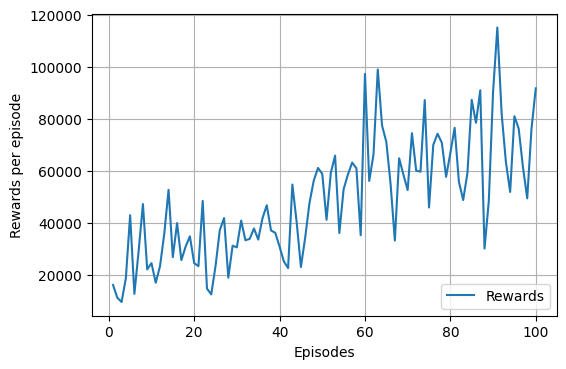

Reward: 73097.07854985833


In [24]:
data = train_1st

env = MultiStockEnv(data)
gamma = 0.95
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 1.0
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 1000
criterion_episodes = 5

scaler = get_scaler(env)

agent = AgentDQN(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 epsilon=epsilon,
                 replay_size=replay_size,
                 minibatch_size=minibatch_size,
                 target_update=target_update,
                 scaler= scaler)


agent.train(max_episodes, lambda x : min(x) >= 100000, criterion_episodes)    # at most $100,000
                                                                              # ask about stop_criterion


# visualise one episode
state = env.reset()
state = scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    
print(f'Reward: {total_reward}')


In [25]:
folder = 'DQN_128x128'

if not os.path.exists(folder):
    os.makedirs(folder)
agent.save(f'{folder}/tradingbotDQN.128x128_1st_another.pt')

with open(f'{folder}/DQN_128x128_scaler_1st_another.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Test The Agent**

In [15]:
data = test_1st

env = MultiStockEnv(data)
gamma = 0.95
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.1
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 1000
criterion_episodes = 5

folder = 'DQN_128x128'
with open(f'{folder}/DQN_128x128_scaler_1st_another.pkl', 'rb') as f:
    test_scaler = pickle.load(f) 


agent = AgentDQN(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 epsilon=epsilon,
                 replay_size=replay_size,
                 minibatch_size=minibatch_size,
                 target_update=target_update,
                 scaler= test_scaler)



agent.load(f'{folder}/tradingbotDQN.128x128_1st_another.pt')



# visualise one episode
state = env.reset()
state = test_scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
rewards = []
portfolio = []
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = test_scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    rewards.append(reward)
    asset = info['cur_val']
    portfolio.append(asset)

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')

Reward: 2497.88248912555, info: 22497.88248912555


(-2300.0, 4000.0)

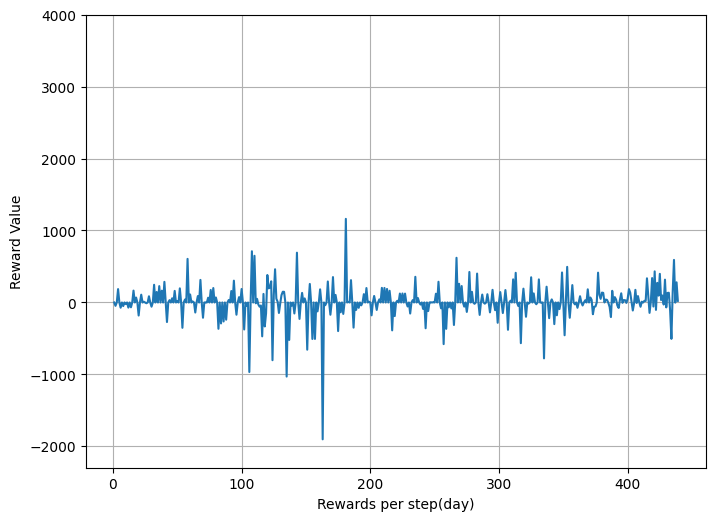

In [22]:
figure(figsize=(8, 6), dpi=100)
plt.plot(range(1, len(rewards)+1), rewards, label=f'Rewards')
plt.grid()
plt.xlabel("Rewards per step(day)")
plt.ylabel("Reward Value")

plt.ylim([-2300, 4000])

In [ ]:
a = np.array(portfolio)
np.save('DQN_ProtoType_Test1.npy', a)

___

# 2nd Split

**The following cells were trained and tested by Jinguo. However, he forgot to save the agents so there is no agent to load from the folder. Please refer to the report for these results**

In [17]:
data = train_2nd

env = MultiStockEnv(data)
gamma = 0.95
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 1.0
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 1000
criterion_episodes = 5

scaler = get_scaler(env)

agent = AgentDQN(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 epsilon=epsilon,
                 replay_size=replay_size,
                 minibatch_size=minibatch_size,
                 target_update=target_update,
                 scaler= scaler)


agent.train(max_episodes, lambda x : min(x) >= 100000, criterion_episodes)    # at most $100,000
                                                                              # ask about stop_criterion


# visualise one episode
state = env.reset()
state = scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    
print(f'Reward: {total_reward}')


In [18]:
folder = 'DQN_128x128'

if not os.path.exists(folder):
    os.makedirs(folder)
agent.save(f'{folder}/tradingbotDQN.128x128_2nd.pt')

with open(f'{folder}/DQN_128x128_scaler_2nd.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Test The Agent**

In [19]:
data = test_2nd

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 1000
criterion_episodes = 5

folder = 'DQN_128x128'
with open(f'{folder}/DQN_128x128_scaler_2nd.pkl', 'rb') as f:
    test_scaler = pickle.load(f) 


agent = AgentDQN(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 epsilon=epsilon,
                 replay_size=replay_size,
                 minibatch_size=minibatch_size,
                 target_update=target_update,
                 scaler= test_scaler)



agent.load(f'{folder}/tradingbotDQN.128x128_2nd.pt')



# visualise one episode
state = env.reset()
state = test_scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = test_scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')

___

# 3rd Split

In [20]:
data = train_3rd

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 1000
criterion_episodes = 50

scaler = get_scaler(env)

agent = AgentDQN(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 epsilon=epsilon,
                 replay_size=replay_size,
                 minibatch_size=minibatch_size,
                 target_update=target_update,
                 scaler= scaler)


agent.train(max_episodes, lambda x : max(x) >= 85000, criterion_episodes)    


# visualise one episode
state = env.reset()
state = scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    
print(f'Reward: {total_reward}')


In [16]:
folder = 'DQN_128x128'

if not os.path.exists(folder):
    os.makedirs(folder)
agent.save(f'{folder}/tradingbotDQN.128x128_3rd.pt')

with open(f'{folder}/DQN_128x128_scaler_3rd.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Test the Agent**

In [21]:
data = test_3rd

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 1000
criterion_episodes = 5

folder = 'DQN_128x128'
with open(f'{folder}/DQN_128x128_scaler_3rd.pkl', 'rb') as f:
    test_scaler = pickle.load(f) 


agent = AgentDQN(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 epsilon=epsilon,
                 replay_size=replay_size,
                 minibatch_size=minibatch_size,
                 target_update=target_update,
                 scaler= test_scaler)



agent.load(f'{folder}/tradingbotDQN.128x128_3rd.pt')



# visualise one episode
state = env.reset()
state = test_scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = test_scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')

___

# 4th Split

In [22]:
data = train_4th

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 1000
criterion_episodes = 5

scaler = get_scaler(env)

agent = AgentDQN(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 epsilon=epsilon,
                 replay_size=replay_size,
                 minibatch_size=minibatch_size,
                 target_update=target_update,
                 scaler= scaler)


agent.train(max_episodes, lambda x : max(x) >= 100000, criterion_episodes)    # at most $100,000
                                                                              # ask about stop_criterion


# visualise one episode
state = env.reset()
state = scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1
    
print(f'Reward: {total_reward}')


In [19]:
folder = 'DQN_128x128'

if not os.path.exists(folder):
    os.makedirs(folder)
agent.save(f'{folder}/tradingbotDQN.128x128_4th.pt')

with open(f'{folder}/DQN_128x128_scaler_4th.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Test the Agent**

In [23]:
data = test_4th

env = MultiStockEnv(data)
gamma = 0.99
hidden_sizes = (128, 128)
learning_rate = 0.001
epsilon = 0.2
replay_size = 10000
minibatch_size = 64
target_update = 20
max_episodes = 100
# max_steps = 1000
criterion_episodes = 5

folder = 'DQN_128x128'
with open(f'{folder}/DQN_128x128_scaler_4th.pkl', 'rb') as f:
    test_scaler = pickle.load(f) 


agent = AgentDQN(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 epsilon=epsilon,
                 replay_size=replay_size,
                 minibatch_size=minibatch_size,
                 target_update=target_update,
                 scaler= test_scaler)



agent.load(f'{folder}/tradingbotDQN.128x128_4th.pt')



# visualise one episode
state = env.reset()
state = test_scaler.transform([state]).reshape(-1,)

terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated):
    # take action based on policy    
    action = agent.policy(state)
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    state = test_scaler.transform([state]).reshape(-1,)
    total_reward += reward
    steps += 1

val = info['cur_val']
print(f'Reward: {total_reward}, info: {val}')